# Stability of Planetary Orbital Configurations Klassifier

We start by making a `StabilityClassifier` instance

In [2]:
from spock import StabilityClassifier
sc = StabilityClassifier()

# Input Format

The input is simply a full set of initial conditions including masses, positions and velocities for the star and all the planets. Note that this is the same as if you wanted to run an N-body integration. The format is in the form of a `Simulation` object from the REBOUND N-body package (https://github.com/hannorein/rebound). This gives you both a useful set of methods for specifying initial conditions (see https://github.com/hannorein/rebound/blob/master/ipython_examples/OrbitalElements.ipynb for details), and the option to visualize and run additional N-body tests. See https://github.com/hannorein/rebound/blob/master/ipython_examples/Units.ipynb for a discussion of units used in REBOUND.

Let's make a simple compact system with small eccentricities and arbitrary longitudes (phases):

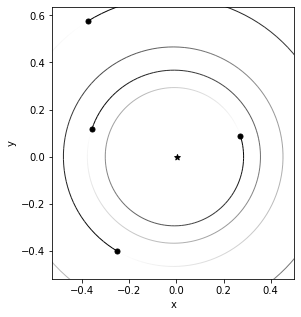

In [3]:
import rebound
%matplotlib inline

sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=1.e-4, P=1., e=0.03, l=0.3)
sim.add(m=1.e-4, P=1.4, e=0.03, l=2.8)
sim.add(m=1.e-4, P=2, e=0.03, l=4.2)
sim.add(m=1.e-4, P=3.5, e=0.03, l=2.1)
sim.move_to_com()
fig = rebound.OrbitPlot(sim)

# Predict stability over 1 billion orbits

Integrating for a billion orbits numerically would take several hours.

In [4]:
%%time
sc.predict_stable(sim)

CPU times: user 621 ms, sys: 8.01 ms, total: 629 ms
Wall time: 634 ms


0.0043392824

# Features

Typically all we want is a probability of stability, but if you are interested you can also explore the short summary features measured in the short integration which we discuss in some detail in our paper. There is a separate set of features for each adjacent trio of planets, in the order they were added to the `Simulation` above (first set is for the planets with indices 1,2,3, the second is for indices 2,3,4, and so on).

In [5]:
sc.generate_features(sim)

([OrderedDict([('EMcrossnear', 0.2515066590722047),
               ('EMfracstdnear', 0.08417647544339914),
               ('EPstdnear', 0.008561370504931836),
               ('MMRstrengthnear', 0.26035697320268697),
               ('EMcrossfar', 0.26847655948338894),
               ('EMfracstdfar', 0.06198314872872217),
               ('EPstdfar', 0.00880628975082175),
               ('MMRstrengthfar', 0.022011060549851292),
               ('MEGNO', 34.99484500182902),
               ('MEGNOstd', 6.827822415952419)]),
  OrderedDict([('EMcrossnear', 0.26847655948338894),
               ('EMfracstdnear', 0.06198314872872217),
               ('EPstdnear', 0.00880628975082175),
               ('MMRstrengthnear', 0.022011060549851292),
               ('EMcrossfar', 0.4522448238086002),
               ('EMfracstdfar', 0.053090344680207145),
               ('EPstdfar', 0.011490859876603102),
               ('MMRstrengthfar', nan),
               ('MEGNO', 34.99484500182902),
               ('